In [2]:
import pymysql
import pandas as pd
import numpy as np
import re
import jieba

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

TENCENT_VECTOR_PATH = '/Users/huan/Desktop/weibo/word_vector/Tencent_AILab_ChineseEmbedding.txt'
MAX_VOCAB_SIZE = 50000
MAX_SEQUENCE_LENGTH = 20
EMBEDDING_DIM = 200

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
conn = pymysql.connect(host = '127.0.0.1', 
                       user = 'root', 
                       password = 'root123', 
                       db = 'delidou')

In [4]:
df = pd.read_sql_query('''
select name, tag from base_goods
union all
select name,tag from base_live_goods 
''', conn)

In [5]:
def find_chinese(file):
    pattern = re.compile(r'[^\u4e00-\u9fa5]')
    chinese = re.sub(pattern, '', file)
    return chinese

def replace_puncs(x):
    return re.sub(r'[^\w\s]','',x)

def remove_blanks(x):
    return re.sub(r'\s{2,}','',x)

def cut_text(x):
    return list(jieba.cut(x,cut_all=False))

def preprocess_texts(df):

    df['clean_name'] = df.name.apply(remove_blanks).apply(replace_puncs).apply(find_chinese).values
    df['cutted_text'] = df.clean_name.apply(cut_text).values
    df['texts'] = df.cutted_text.apply(lambda x:' '.join(x)).values
    df.loc[:,'sequence_length'] = df.cutted_text.apply(lambda x:len(x)).values
    df = df[(df.sequence_length >0) & (df.sequence_length <= MAX_SEQUENCE_LENGTH)]
    return df

In [6]:
df = preprocess_texts(df)

Building prefix dict from the default dictionary ...
I0809 14:11:54.239439 4478541248 __init__.py:111] Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/jh/q3qgwx4n59b_rg88dkbcb20m0000gn/T/jieba.cache
I0809 14:11:54.246527 4478541248 __init__.py:131] Loading model from cache /var/folders/jh/q3qgwx4n59b_rg88dkbcb20m0000gn/T/jieba.cache
Loading model cost 0.670 seconds.
I0809 14:11:54.911530 4478541248 __init__.py:163] Loading model cost 0.670 seconds.
Prefix dict has been built succesfully.
I0809 14:11:54.913481 4478541248 __init__.py:164] Prefix dict has been built succesfully.


In [7]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df.texts)
num_words = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)
print('Number of word considered: {}'.format(num_words))
word2index = tokenizer.word_index

Number of word considered: 50000


In [8]:
sequences = tokenizer.texts_to_sequences(df.texts)

In [9]:
padded_sequences = pad_sequences(sequences,maxlen = MAX_SEQUENCE_LENGTH)

In [10]:
embeddings_index = dict()
with open(TENCENT_VECTOR_PATH,'r', encoding = 'utf-8') as f:
    next(f)
    for line in f:
        values = line.split(' ')
        word = values[0]
        if word in word2index:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    f.close()
    
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, ind in word2index.items():
    if ind < MAX_VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[ind] = embedding_vector

In [14]:
from keras.layers import Input,Dense, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding,concatenate,Flatten
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [15]:
nonnull_index = np.where((df.tag != '').values)[0]
features = padded_sequences[nonnull_index]
targets = pd.Categorical(df.iloc[nonnull_index,:]['tag'])
idx_to_cat = {idx:cat for idx, cat in enumerate(pd.Categorical(targets.categories))}
targets = targets.codes
K = max(idx_to_cat) + 1

In [16]:
embedding_layer = Embedding(num_words,
                    EMBEDDING_DIM,
                    weights = [embedding_matrix],
                    input_length = MAX_SEQUENCE_LENGTH,
                    trainable = False)

inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = Embedding(input_dim=num_words, output_dim=200, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix],trainable=False)(inputs)
l_conv01 = Conv1D(128, 3,activation='relu',padding='same')(embedded_sequences)
l_pool01 = MaxPooling1D(3)(l_conv01)
l_conv02 = Conv1D(128, 4,activation='relu',padding='same')(embedded_sequences)
l_pool02 = MaxPooling1D(5)(l_conv02)
l_conv03 = Conv1D(128, 5,activation='relu',padding='same')(embedded_sequences)
l_pool03 = MaxPooling1D(5)(l_conv03)
l_merge = concatenate([l_pool01,l_pool02,l_pool03],axis=1)

l_cov2 = Conv1D(128, 3, activation='relu',padding='same')(l_merge)
l_pool2 = MaxPooling1D(10)(l_cov2)
l_pool2 = Flatten()(l_pool2)
l_dense = Dense(128, activation='relu')(l_pool2)
encoder = Model(inputs, l_dense)

encoded_vector = encoder(inputs)

preds = Dense(K, activation='softmax')(encoded_vector)

model=Model(inputs,preds)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [17]:
from keras.utils import plot_model

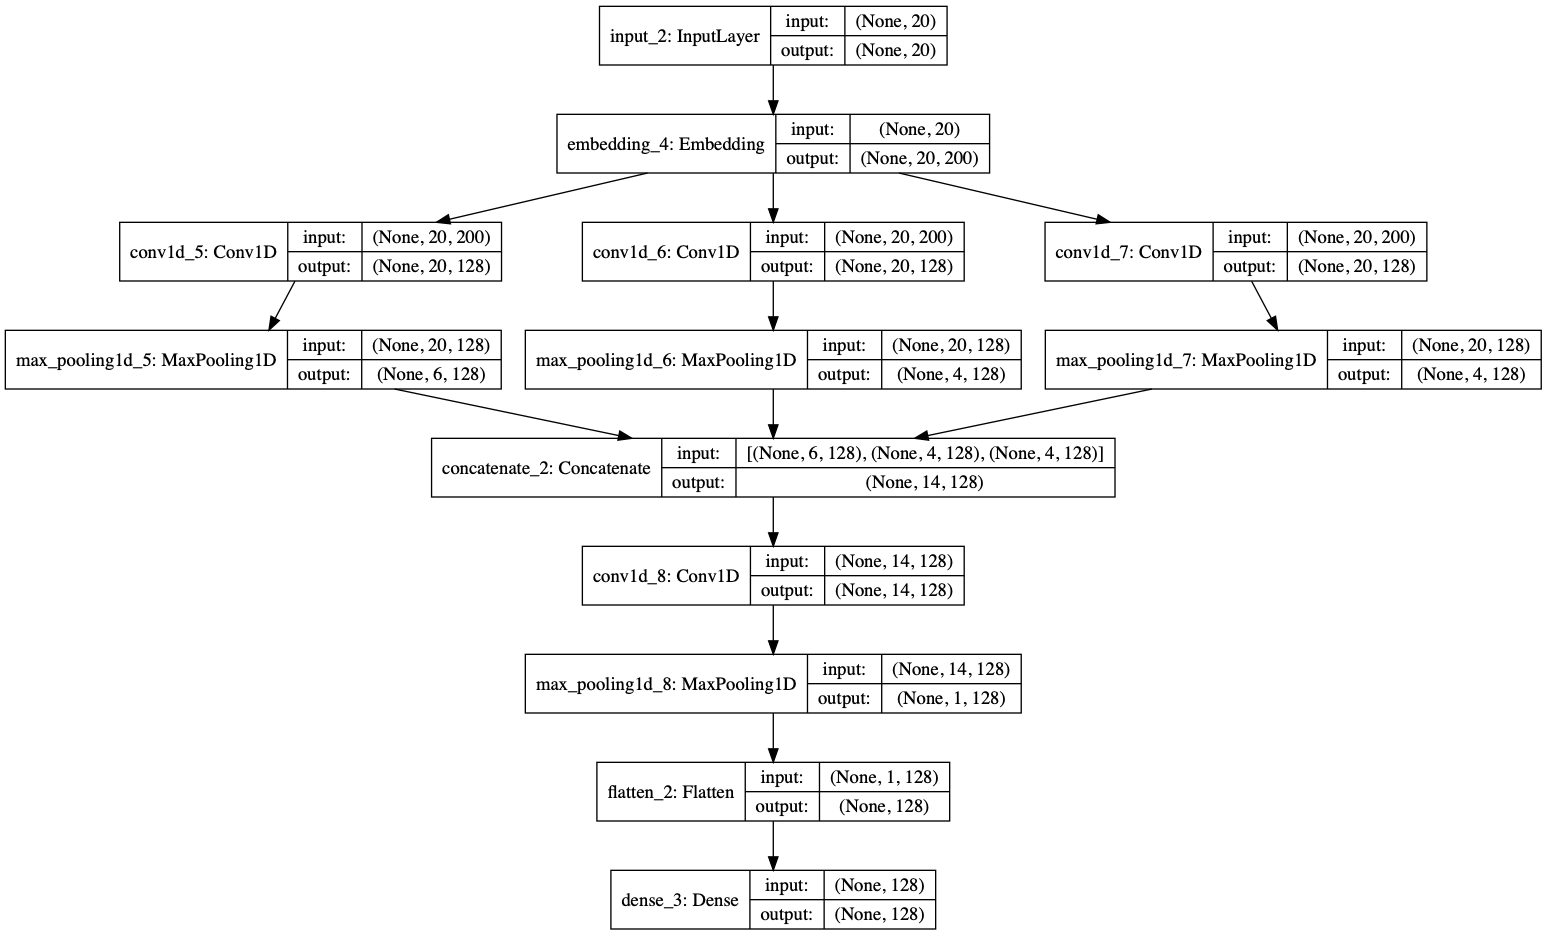

In [18]:
plot_model(encoder,show_shapes=True)

In [20]:
model.fit(features, targets,batch_size =128,epochs = 7,validation_split = 0.3)

In [21]:
padded_sequences = pad_sequences(tokenizer.texts_to_sequences(preprocess_texts(df[df.tag == '']).texts), maxlen = MAX_SEQUENCE_LENGTH)
preds = model.predict(padded_sequences).argmax(axis = 1)

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [22]:
tmp = df[df.tag == '']

In [23]:
tmp['predictions'] = [idx_to_cat[p] for p in preds]

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
encoder.predict(padded_sequences).shape

(68029, 128)

In [25]:
tmp.head(100)

,name,tag,clean_name,cutted_text,texts,sequence_length,predictions
1,【橙子快跑】无蔗糖全麦面包南瓜藜麦健康粗纤健身代早餐600g,,橙子快跑无蔗糖全麦面包南瓜藜麦健康粗纤健身代早餐,"[橙子, 快, 跑, 无, 蔗糖, 全麦, 面包, 南瓜, 藜, 麦, 健康, 粗纤, 健身...",橙子 快 跑 无 蔗糖 全麦 面包 南瓜 藜 麦 健康 粗纤 健身 代 早餐,15,食品
3,东菱早餐机多功能三合一家用三明治宿舍锅学生锅电热煮锅懒人神器,,东菱早餐机多功能三合一家用三明治宿舍锅学生锅电热煮锅懒人神器,"[东菱, 早餐, 机, 多功能, 三合, 一家, 用, 三明治, 宿舍, 锅, 学生, 锅,...",东菱 早餐 机 多功能 三合 一家 用 三明治 宿舍 锅 学生 锅 电热 煮 锅 懒人 神器,17,百货
6,WRZ i7耳机原装正品适用苹果6s华为oppo小米vivo入耳式有线高音质,,耳机原装正品适用苹果华为小米入耳式有线高音质,"[耳机, 原装, 正品, 适用, 苹果, 华为, 小米, 入耳式, 有线, 高音质]",耳机 原装 正品 适用 苹果 华为 小米 入耳式 有线 高音质,10,手机
15,一次性洗脸巾纯棉压缩毛巾旅行装浴巾女旅游酒店用品便携床单枕套,,一次性洗脸巾纯棉压缩毛巾旅行装浴巾女旅游酒店用品便携床单枕套,"[一次性, 洗脸, 巾, 纯棉, 压缩, 毛巾, 旅行装, 浴巾, 女, 旅游, 酒店用品,...",一次性 洗脸 巾 纯棉 压缩 毛巾 旅行装 浴巾 女 旅游 酒店用品 便携 床单 枕套,14,百货
16,工装短裤女高腰夏宽松2019新款韩版显瘦bf风休闲潮ins五分裤外穿,,工装短裤女高腰夏宽松新款韩版显瘦风休闲潮五分裤外穿,"[工装, 短裤, 女高, 腰夏, 宽松, 新款, 韩版显, 瘦风, 休闲, 潮, 五分裤, 外穿]",工装 短裤 女高 腰夏 宽松 新款 韩版显 瘦风 休闲 潮 五分裤 外穿,12,女装
...,...,...,...,...,...,...,...
658,好日子即食香辣鱼皮麻辣鱼皮海鲜零食油炸鱼片鱼干小吃网红零食,,好日子即食香辣鱼皮麻辣鱼皮海鲜零食油炸鱼片鱼干小吃网红零食,"[好日子, 即食, 香辣, 鱼皮, 麻辣, 鱼皮, 海鲜, 零食, 油炸, 鱼片, 鱼干, ...",好日子 即食 香辣 鱼皮 麻辣 鱼皮 海鲜 零食 油炸 鱼片 鱼干 小吃 网红 零食,14,食品
662,湘嘴巴手撕素肉素牛排20包豆腐干网红麻辣条卤味零食休闲小吃素食,,湘嘴巴手撕素肉素牛排包豆腐干网红麻辣条卤味零食休闲小吃素食,"[湘, 嘴巴, 手, 撕素, 肉素, 牛排, 包, 豆腐干, 网红, 麻辣, 条, 卤味, ...",湘 嘴巴 手 撕素 肉素 牛排 包 豆腐干 网红 麻辣 条 卤味 零食 休闲 小吃 素食,16,食品
663,创意树叶肥皂盒浴室免打孔吸盘香皂盒架卫生间沥水洗衣皂盒置物架,,创意树叶肥皂盒浴室免打孔吸盘香皂盒架卫生间沥水洗衣皂盒置物架,"[创意, 树叶, 肥皂盒, 浴室, 免, 打孔, 吸盘, 香皂盒, 架, 卫生间, 沥水, ...",创意 树叶 肥皂盒 浴室 免 打孔 吸盘 香皂盒 架 卫生间 沥水 洗衣 皂盒 置物架,14,百货
664,真无线蓝牙耳机双耳迷你iphone适用于oopp华为vivo苹果安卓通用型,,真无线蓝牙耳机双耳迷你适用于华为苹果安卓通用型,"[真, 无线, 蓝牙, 耳机, 双耳, 迷你, 适用, 于, 华为, 苹果, 安卓, 通用型]",真 无线 蓝牙 耳机 双耳 迷你 适用 于 华为 苹果 安卓 通用型,12,手机


In [26]:
import pickle
import json
import os

In [29]:
model_config = {"EMBEDDING_DIM":EMBEDDING_DIM, 'num_words':num_words,'MAX_SEQUENCE_LENGTH':MAX_SEQUENCE_LENGTH,'K':K}

In [30]:
np.save('/Users/huan/Desktop/delidou/item_embedding/resources/embedding_matrix.npy',embedding_matrix)
pickle.dump(tokenizer,open('/Users/huan/Desktop/delidou/item_embedding/resources/tokenizer.pkl','wb'))
model.save_weights('/Users/huan/Desktop/delidou/item_embedding/resources/item_embedding_model.h5')
encoder.save_weights('/Users/huan/Desktop/delidou/item_embedding/resources/item_encoding.h5')
model.save('/Users/huan/Desktop/delidou/item_embedding/resources/item_type_prediction_model.h5')
encoder.save('/Users/huan/Desktop/delidou/item_embedding/resources/encoder_model.h5')
pickle.dump(model_config, open('/Users/huan/Desktop/delidou/item_embedding/resources/model_config.pkl','wb'))
pickle.dump(idx_to_cat, open('/Users/huan/Desktop/delidou/item_embedding/resources/idx_to_cat.pkl','wb'))
encoder_json = encoder.to_json()
json.dump(encoder_json,open('/Users/huan/Desktop/delidou/item_embedding/resources/item_encoding.json','w'))

In [31]:
from keras.models import model_from_json
loaded_model = model_from_json(json.loads(open('/Users/huan/Desktop/delidou/item_embedding/resources/item_encoding.json').read()))
loaded_model.load_weights('/Users/huan/Desktop/delidou/item_embedding/resources/item_encoding.h5')

In [32]:
loaded_model.predict(padded_sequences)

array([[2.7813294, 5.660997 , 0.       , ..., 3.0601206, 0.       ,
        2.9711096],
       [0.8739063, 2.603032 , 0.       , ..., 1.8913505, 0.       ,
        1.6181711],
       [0.       , 2.3945858, 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [2.6380918, 2.6058936, 0.       , ..., 1.7848125, 0.       ,
        0.4836478],
       [2.0031154, 2.183725 , 0.       , ..., 3.4047952, 0.       ,
        1.8910452],
       [3.88773  , 3.793517 , 0.       , ..., 4.5867877, 0.       ,
        0.       ]], dtype=float32)